# LGBM

In [1]:
import pandas as pd
import os
import random
import numpy as np

## 1. 데이터 로딩

In [2]:
data_dir = '/opt/ml/input/data' # data 경로 지정
csv_file_path = os.path.join(data_dir, 'train_data.csv')
df = pd.read_csv(csv_file_path, parse_dates=["Timestamp"]) 

## 2. Feature Engineering

In [3]:
from feature_engineering import get_features

df = get_features(df)
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,correct_shift_-2,...,relative_time,test_mean,test_sum,tag_mean,tag_sum,assess_mean,assess_sum,user_mean,user_sum,correct_per_hour
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,1.0,...,-27.0,0.947683,1268,0.955022,637,0.982063,219,0.630872,470,0.649446
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.0,1.0,...,-24.0,0.947683,1268,0.913187,3040,0.964126,215,0.630872,470,0.649446
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.0,1.0,...,-19.0,0.947683,1268,0.913187,3040,0.910314,203,0.630872,470,0.649446
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.0,1.0,...,-20.0,0.947683,1268,0.913187,3040,0.968610,216,0.630872,470,0.649446
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.0,0.0,...,-20.0,0.947683,1268,0.913187,3040,0.941704,210,0.630872,470,0.649446


In [4]:
# 사용할 Feature 설정

cate_cols=[#"assessmentItemID", 
           #"testId", 
           "KnowledgeTag", 
           "correct_shift_-2", 
           "correct_shift_-1", 
           "correct_shift_1", 
           "correct_shift_2",
           #"hour", 
           "hour_mode",                 
           ]
    
cont_cols=["user_acc", 
           #"user_correct_answer", 
           #"user_total_answer", 
           #"future_correct", 
           "average_content_correct", 
           "mean_time", 
           #"time_median",
           #"correct_per_hour", 
           "time", 
           #"normalized_time",
           #"relative_time", 
           "assess_mean", 
           "assess_sum", 
           "tag_mean", 
           "tag_sum", 
           "test_mean", 
           "test_sum",
           "user_mean",
           #"user_sum",
           ]
           
FEATS = cate_cols + cont_cols

## Data preprocessing

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data distribution 파악
# for col in list(cont_cols):
#     plt.figure(figsize=(10,5))
#     df[col].hist()
    
#     plt.grid('False')
#     plt.title('histogram of ' + str(col))
#     plt.xlabel(str(col));
#     plt.ylabel('count');

In [6]:
from sklearn.preprocessing import StandardScaler

# standard scaling 적용
# std_scaler = StandardScaler()
# fitted = std_scaler.fit(df[cont_cols])
# print(fitted.mean_)

In [7]:
# output = std_scaler.transform(df[cont_cols])
# output = pd.DataFrame(output, columns=df[cont_cols].columns)
# output.head()

In [8]:
# standard scaler 적용 후 data distribution 파악

# for col in list(output.columns):
#     plt.figure(figsize=(10,5))
#     output[col].hist()
    
#     plt.grid('False')
#     plt.title('histogram of ' + str(col))
#     plt.xlabel(str(col));
#     plt.ylabel('count');

In [9]:
# data distribution에서 skew가 발생한 경우 log scaling 적용

# log1p_cols = [#"user_correct_answer", 
#               #"user_total_answer", 
#               #"future_correct", 
#               "average_content_correct", 
#               "mean_time", 
#               #"time_median",
#               "time", 
#               #"normalized_time",
#               #"relative_time", 
#               ]

# output[log1p_cols] = np.log1p(output[log1p_cols])
# df[cont_cols] = output

In [10]:
# 최종 distribution 확인

# for col in list(output.columns):
#     plt.figure(figsize=(10,5))
#     output[col].hist()
    
#     plt.grid('False')
#     plt.title('histogram of ' + str(col))
#     plt.xlabel(str(col));
#     plt.ylabel('count');

## 3. Train/Test 데이터 셋 분리

In [11]:
from util import setSeeds, custom_train_test_split, get_eval

setSeeds(42)

# 유저별 분리
train, test = custom_train_test_split(df, ratio=0.99)

In [12]:
# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [13]:
train

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,correct_shift_-2,correct_shift_-1,...,relative_time,test_mean,test_sum,tag_mean,tag_sum,assess_mean,assess_sum,user_mean,user_sum,correct_per_hour
0,0,A060001001,A060000001,2020-03-24 00:17:11,7224,NaN,0,NaN,1.0,1.0,...,-27.0,0.947683,1268,0.955022,637,0.982063,219,0.630872,470,0.649446
1,0,A060001002,A060000001,2020-03-24 00:17:14,7225,1.0,1,1.000000,1.0,1.0,...,-24.0,0.947683,1268,0.913187,3040,0.964126,215,0.630872,470,0.649446
2,0,A060001003,A060000001,2020-03-24 00:17:22,7225,2.0,2,1.000000,1.0,1.0,...,-19.0,0.947683,1268,0.913187,3040,0.910314,203,0.630872,470,0.649446
3,0,A060001004,A060000001,2020-03-24 00:17:29,7225,3.0,3,1.000000,1.0,1.0,...,-20.0,0.947683,1268,0.913187,3040,0.968610,216,0.630872,470,0.649446
4,0,A060001005,A060000001,2020-03-24 00:17:36,7225,4.0,4,1.000000,0.0,1.0,...,-20.0,0.947683,1268,0.913187,3040,0.941704,210,0.630872,470,0.649446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,2020-06-05 06:50:21,438,1.0,4,0.250000,1.0,1.0,...,-16.0,0.662590,921,0.689706,2814,0.435252,121,0.555556,5,0.629941
2266582,7441,A040165001,A040000165,2020-08-21 01:06:39,8836,1.0,5,0.200000,1.0,1.0,...,6632138.0,0.655109,718,0.697874,2199,0.649635,178,0.555556,5,0.644321
2266583,7441,A040165002,A040000165,2020-08-21 01:06:50,8836,2.0,6,0.333333,1.0,1.0,...,-29.0,0.655109,718,0.697874,2199,0.635036,174,0.555556,5,0.644321
2266584,7441,A040165003,A040000165,2020-08-21 01:07:36,8836,3.0,7,0.428571,NaN,1.0,...,6.0,0.655109,718,0.697874,2199,0.791971,217,0.555556,5,0.644321


## 4. 훈련 및 검증

In [14]:
#!pip install lightgbm

In [15]:
import lightgbm as lgb

lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

In [16]:
model = lgb.train({'objective': 'binary',
                   'metric' : 'binary_logloss',
                   #'metric' : 'auc',
                   'learning_rate' : '0.01',
                   'boosting' : 'dart'}, 
                   lgb_train,
                   valid_sets=[lgb_train, lgb_test],
                   verbose_eval=100,
                   num_boost_round=1000)

pred_probs = model.predict(test[FEATS])

get_eval(y_test, np.where(pred_probs>=0.5, 1, 0))

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1468051, number of negative: 775855
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2833
[LightGBM] [Info] Number of data points in the train set: 2243906, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654239 -> initscore=0.637725
[LightGBM] [Info] Start training from score 0.637725
[100]	training's binary_logloss: 0.563376	valid_1's binary_logloss: 0.630245
[200]	training's binary_logloss: 0.53838	valid_1's binary_logloss: 0.601162
[300]	training's binary_logloss: 0.511999	valid_1's binary_logloss: 0.582163
[400]	training's binary_logloss: 0.493456	valid_1's binary_logloss: 0.570431
[500]	training's binary_logloss: 0.479418	valid_1's binary_logloss: 0.562367
[600]	training's binary_logloss: 0.475928	valid_1's 

## selection된 column correlation

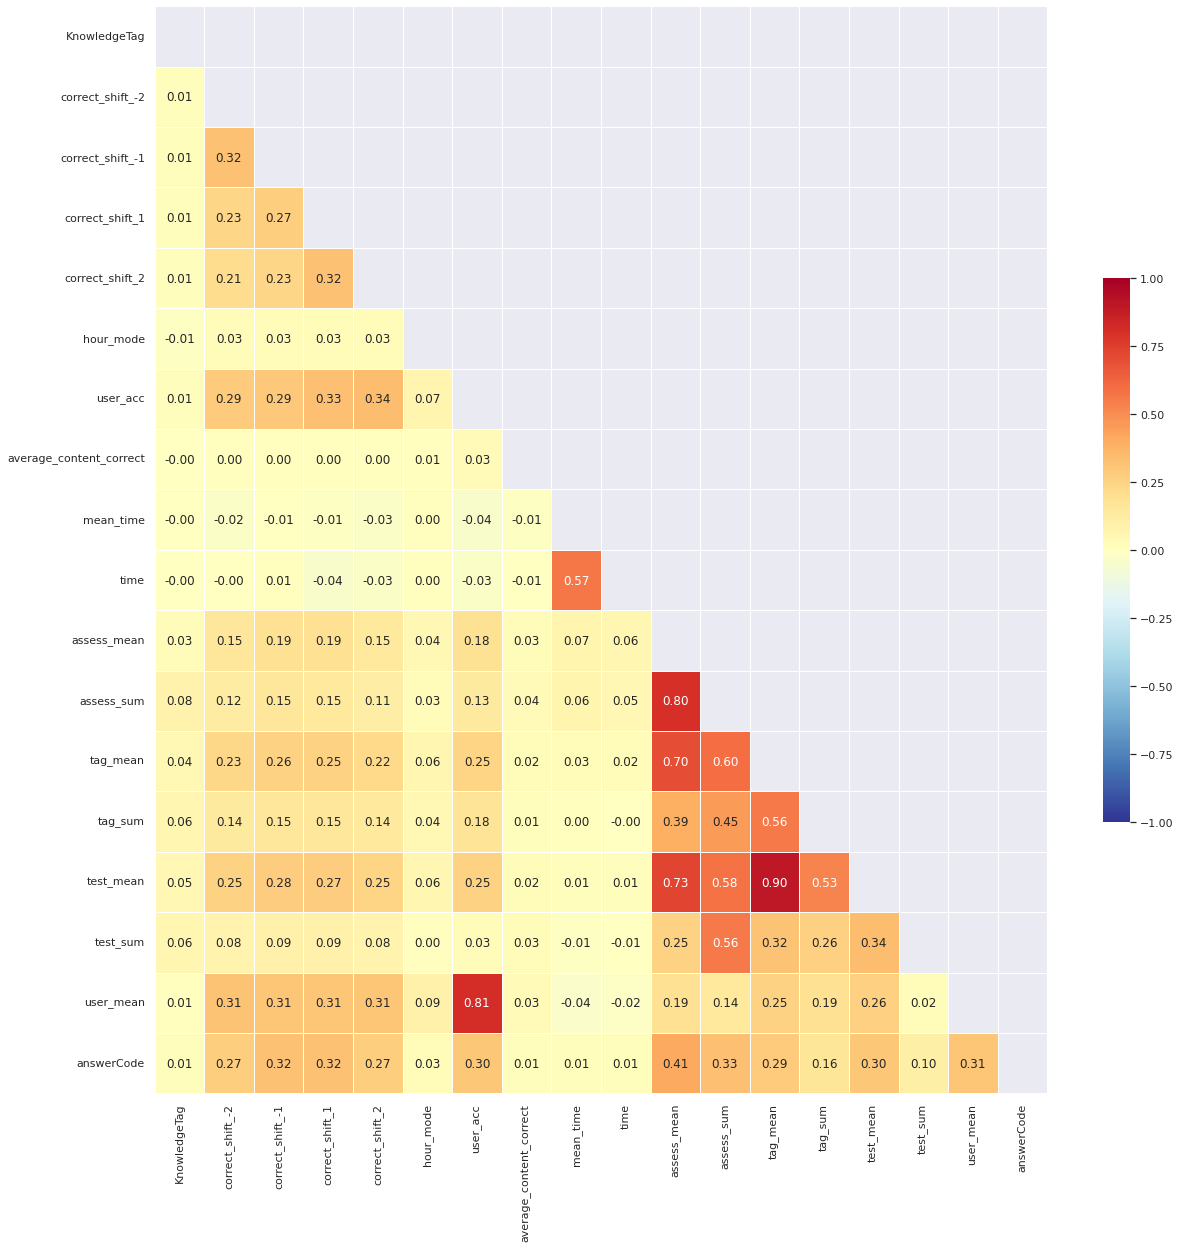

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

col_features = FEATS+['answerCode']

df_corr = df[col_features].corr()
# 그림 사이즈 지정
fig, ax = plt.subplots(figsize=(20,20))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(df_corr, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            fmt = '.2f',    # 소수점 2자리수까지 표현
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

## Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

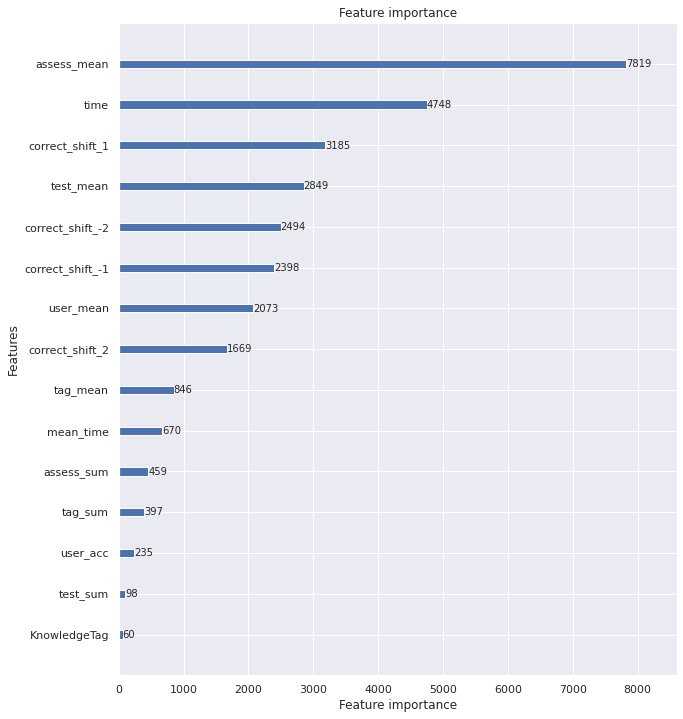

In [18]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(model, ax=ax)

## 5. Inference

In [19]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path, parse_dates=["Timestamp"])

# FEATURE ENGINEERING
test_df = get_features(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]
y_test_df = test_df['answerCode']

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [20]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [21]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "lgbm_feature.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/lgbm_feature.csv
